In [1]:
# take 10% of images from each class to validation

In [2]:
# there are B&W images in data!

In [1]:
import os
from datetime import datetime
from typing import Tuple

from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

### Data

In [2]:
class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
# for debugging - will remove
N_CLASSES_TO_USE = 20

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    
    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [4]:
print(train_split[0])
len(train_split), len(val_split)

('n02437312_229.JPEG', 'n02437312')


(9000, 1000)

In [79]:
train_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

In [ ]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [8]:
X, Y = next(iter(train_dataloader))
X.shape, Y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

---

### Model

In [9]:
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [10]:
class CnnBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, *args, n_conv_layers = 1):
    super().__init__()

    layers = [
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  padding=kernel_size // 2),
        nn.ReLU()
    ]

    for _ in range(n_conv_layers - 1):
        layers.append(nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2))
        layers.append(nn.ReLU())

    self.conv_layers = nn.Sequential(*layers)
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.pool(x)
    return x


class FcBlock(nn.Module):
    def __init__(self, in_shape: int, 
                 out_shape: int, 
                 do_batchnorm: bool = True, 
                 activation: nn.Module = None):
        super().__init__()
        layers = []

        if do_batchnorm:
            layers.append(nn.BatchNorm1d(in_shape))

        layers.append(nn.Linear(in_shape, out_shape))

        if activation is not None:
            layers.append(activation)
            
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [11]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [12]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CnnBlock(3, 32, kernel_size=5)
        self.conv2 = CnnBlock(32, 64, kernel_size=5)
        self.conv3 = CnnBlock(64, 128, kernel_size=3)
        self.conv4 = CnnBlock(128, 64, kernel_size=3)

        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = FcBlock(64 * 4 * 4, 512, do_batchnorm=True, activation=nn.ReLU())
        
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = FcBlock(512, 200, do_batchnorm=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)

        x = self.drop1(x)
        x = self.fc1(x)

        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [13]:
model = BaselineModel()

out = model(X)
out.shape

torch.Size([128, 200])

---

### Train

In [14]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [15]:
set_seed(123)

model = BaselineModel()
model.to(DEVICE)

Random seed set as 123


BaselineModel(
  (conv1): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop1

In [164]:
train_config = {
    'n_epochs': 25,
    'lr': 0.005,
    'batch_size': 128,
}

optimizer = optim.Adam(model.parameters(), lr=train_config['lr'])
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

In [165]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        optimizer.zero_grad()
    
        preds = model(X.to(DEVICE)).cpu()
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    
    return avg_loss, accuracy

In [166]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            preds = model(X.to(DEVICE)).cpu()
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [167]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()

		 ------------------------------ EPOCH: 1 ------------------------------
[19:02:15] Step 20/71: train loss = 4.32454
[19:02:19] Step 40/71: train loss = 3.75663
[19:02:24] Step 60/71: train loss = 3.41421
VALIDATION LOSS = 2.64187, VALIDATION ACCURACY = 0.219


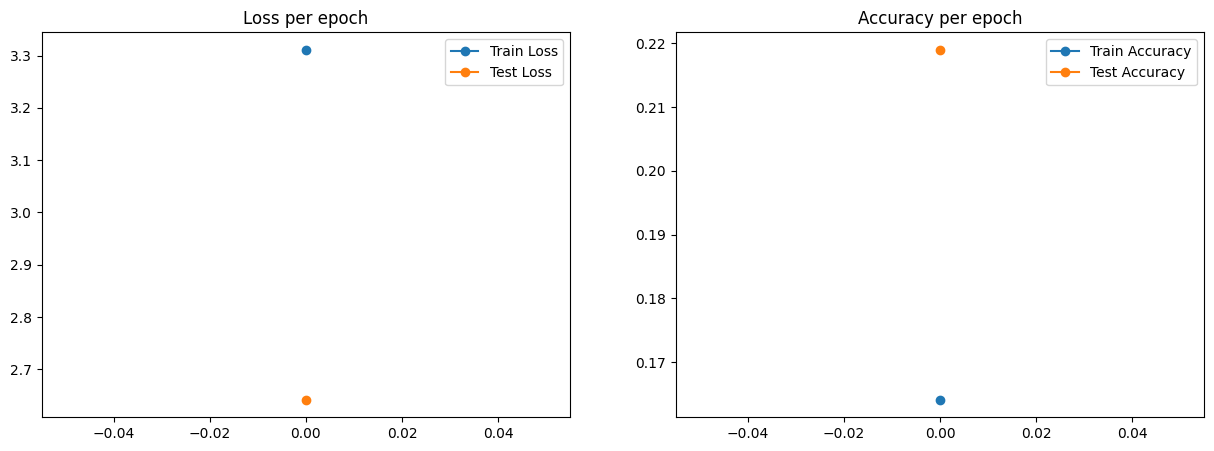

Saving best model
		 ------------------------------ EPOCH: 2 ------------------------------
[19:02:31] Step 20/71: train loss = 2.60416
[19:02:35] Step 40/71: train loss = 2.69781
[19:02:38] Step 60/71: train loss = 2.69675
VALIDATION LOSS = 2.63617, VALIDATION ACCURACY = 0.224


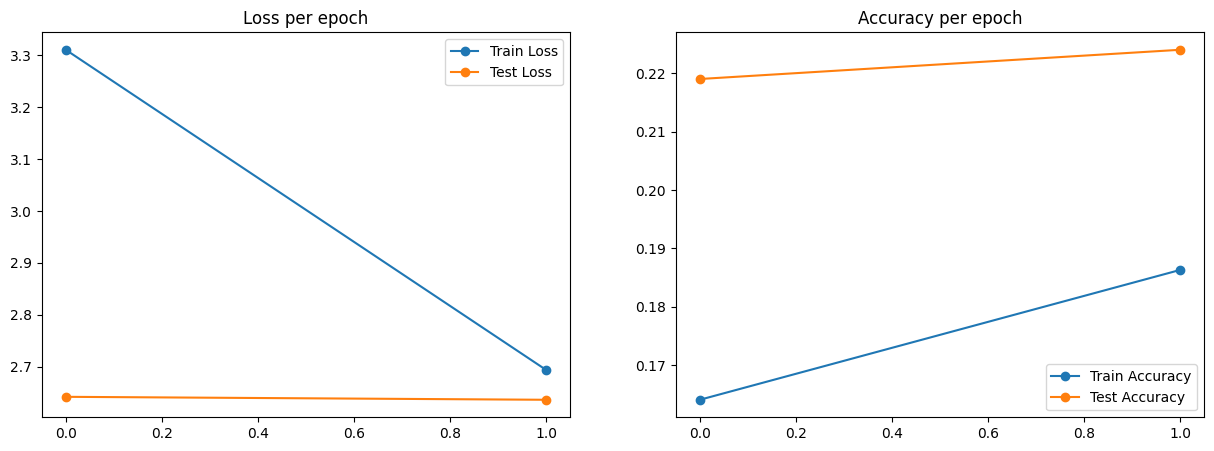

Saving best model
		 ------------------------------ EPOCH: 3 ------------------------------
[19:02:45] Step 20/71: train loss = 2.58757
[19:02:49] Step 40/71: train loss = 2.61626
[19:02:52] Step 60/71: train loss = 2.59722
VALIDATION LOSS = 2.43113, VALIDATION ACCURACY = 0.257


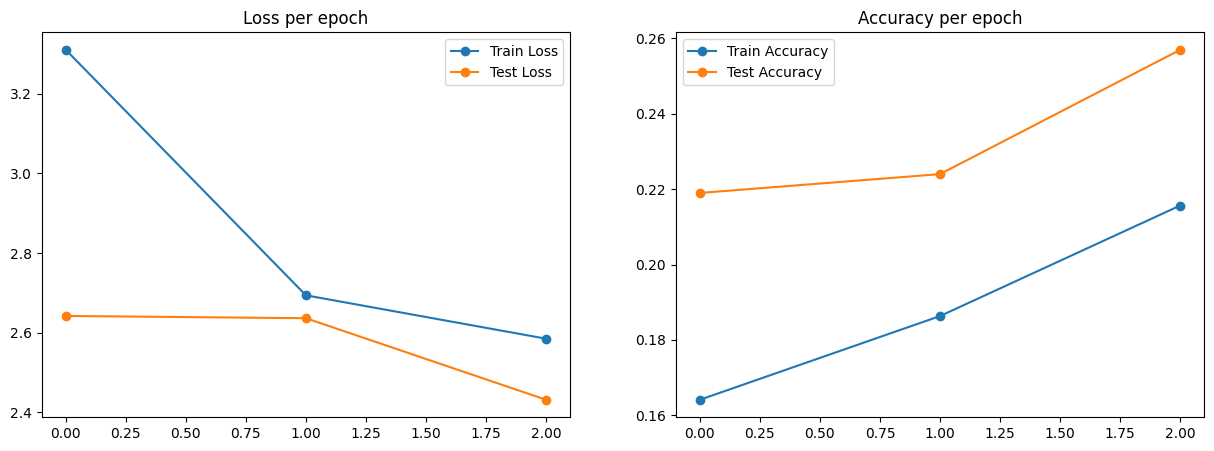

Saving best model
		 ------------------------------ EPOCH: 4 ------------------------------
[19:02:59] Step 20/71: train loss = 2.41814
[19:03:03] Step 40/71: train loss = 2.40322
[19:03:07] Step 60/71: train loss = 2.38523
VALIDATION LOSS = 2.38175, VALIDATION ACCURACY = 0.275


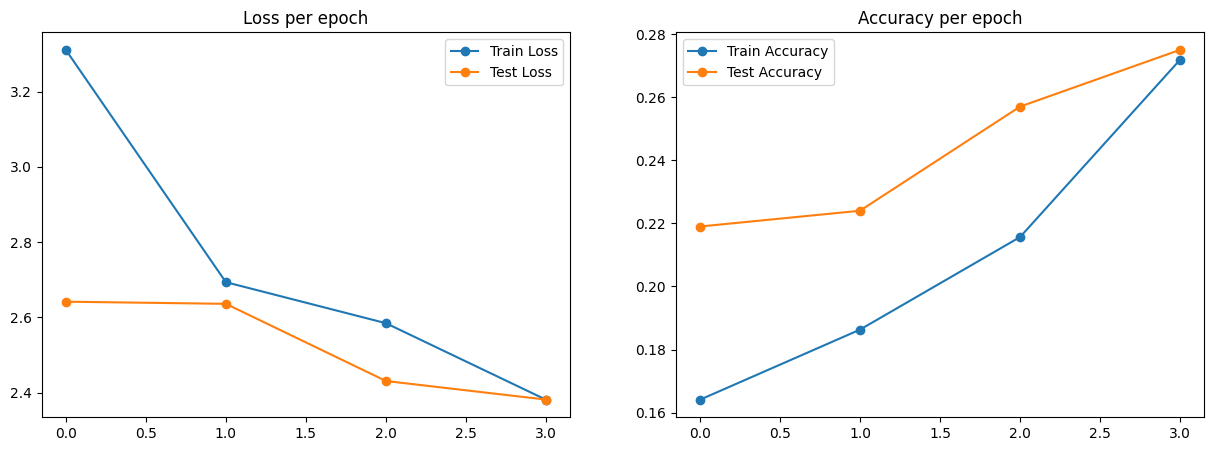

Saving best model
		 ------------------------------ EPOCH: 5 ------------------------------
[19:03:14] Step 20/71: train loss = 2.28357
[19:03:18] Step 40/71: train loss = 2.26422
[19:03:21] Step 60/71: train loss = 2.25904
VALIDATION LOSS = 2.20274, VALIDATION ACCURACY = 0.343


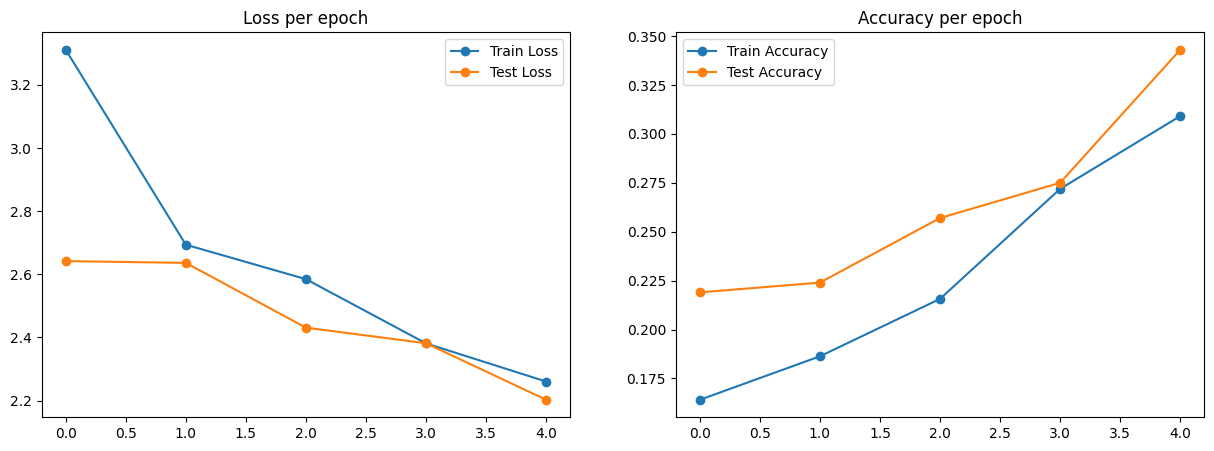

Saving best model
		 ------------------------------ EPOCH: 6 ------------------------------
[19:03:28] Step 20/71: train loss = 2.19047
[19:03:32] Step 40/71: train loss = 2.49472
[19:03:35] Step 60/71: train loss = 2.55437
VALIDATION LOSS = 2.67123, VALIDATION ACCURACY = 0.206


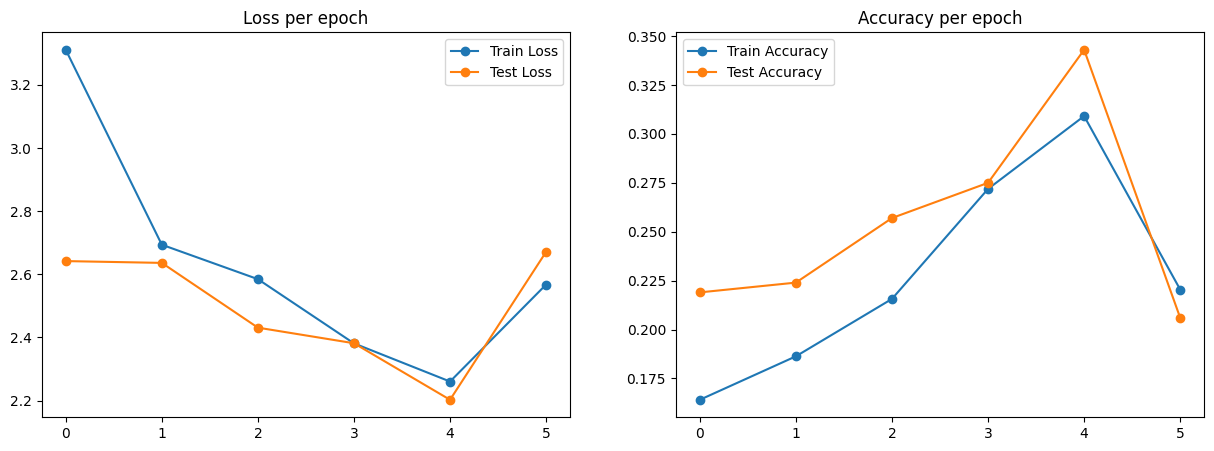

Validation loss didn't improve
		 ------------------------------ EPOCH: 7 ------------------------------
[19:03:42] Step 20/71: train loss = 2.5211
[19:03:46] Step 40/71: train loss = 2.50712
[19:03:49] Step 60/71: train loss = 2.50504
VALIDATION LOSS = 6.89531, VALIDATION ACCURACY = 0.218


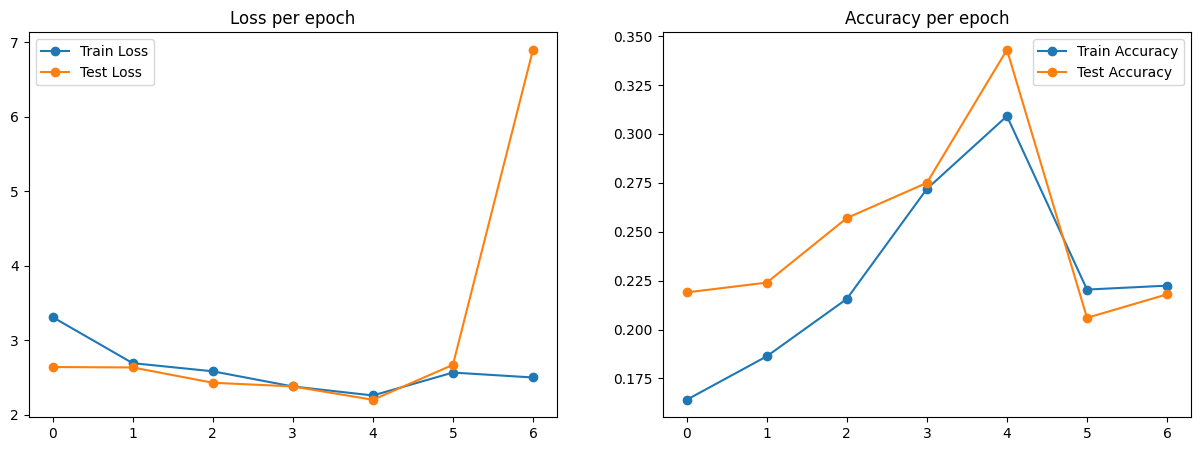

Validation loss didn't improve
EARLY STOPPING: min test_loss 2.20274, last 2 epochs min: 2.67123
Restoring the model at epoch 4: test_accuracy = 0.343
Model successfully restored
Model is stored to model_epoch_4_test_acc_0.343.pth


In [168]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}

for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-2:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-2:])}')
        print(f'Restoring the model at epoch {best_epoch}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break

    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [51]:
import pandas as pd

In [55]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [56]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [57]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [70]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[22:12:31] Step 10/79 done
[22:12:34] Step 20/79 done
[22:12:36] Step 30/79 done
[22:12:39] Step 40/79 done
[22:12:42] Step 50/79 done
[22:12:44] Step 60/79 done
[22:12:47] Step 70/79 done


In [76]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

,ID,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [77]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

0

In [78]:
test_predictions_df['class'].value_counts()

class
0    10000
Name: count, dtype: int64

In [81]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)

In [82]:
test_predictions_df.head()

,ID,class
0,0,n02437312
1,1,n02437312
2,2,n02437312
3,3,n02437312
4,4,n02437312


In [83]:
test_predictions_df.to_csv('../working/submission.csv', index=False)